In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
%matplotlib inline

In [12]:
data = pd.read_csv('data_cleaned.csv',index_col = 'InvoiceDate')

In [13]:
data.index = pd.to_datetime(data.index, format = '%Y-%m-%d %H:%M')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 532820 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     532820 non-null  object 
 1   StockCode     532820 non-null  object 
 2   Description   532820 non-null  object 
 3   Quantity      532820 non-null  int64  
 4   UnitPrice     532820 non-null  float64
 5   CustomerID    403890 non-null  float64
 6   Country       532820 non-null  object 
 7   FinalPrice    532820 non-null  float64
 8   InvoiceMonth  532820 non-null  object 
 9   Day of week   532820 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 44.7+ MB


In [15]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,FinalPrice,InvoiceMonth,Day of week
InvoiceDate,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.95,17850.0,UNITED KINGDOM,17.7,December,Wednesday
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.75,17850.0,UNITED KINGDOM,22.5,December,Wednesday
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,4.15,17850.0,UNITED KINGDOM,33.2,December,Wednesday
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.75,17850.0,UNITED KINGDOM,22.5,December,Wednesday
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,4.25,17850.0,UNITED KINGDOM,25.5,December,Wednesday


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532820 entries, 2010-12-01 08:26 to 2011-12-09 12:50
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     532820 non-null  object 
 1   StockCode     532820 non-null  object 
 2   Description   532820 non-null  object 
 3   Quantity      532820 non-null  int64  
 4   UnitPrice     532820 non-null  float64
 5   CustomerID    403890 non-null  float64
 6   Country       532820 non-null  object 
 7   FinalPrice    532820 non-null  float64
 8   InvoiceMonth  532820 non-null  object 
 9   Day of week   532820 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 44.7+ MB


In [16]:
data.describe().iloc[:,:2]

,Quantity,UnitPrice
count,532820.000000,532820.000000
mean,9.682906,2.710835
std,28.941307,2.600891
min,-960.000000,0.040000
25%,1.000000,1.250000
50%,3.000000,1.950000
75%,10.000000,3.750000
max,1056.000000,16.950000


Since from our analysis, we found that most of the transactions are from inside UK, we decided to comstruct a new feature which denotes whether the customer belongs to UK or outside UK.
We also decided to comstruct features that give aggregate results for each customer like Avergae quantity purchased, average unit price, number of unique invoices generated and number of unique products purchased.


In [18]:
data_copy = data.copy()
data_copy['Country'] = data_copy['Country'].map(lambda x: 'No' if x=='UNITED KINGDOM' else 'Yes')
Customer_Data = data_copy.groupby(['CustomerID','Country'], sort=False).agg({'Quantity':'mean','UnitPrice':'mean','InvoiceNo':'nunique','Description':'nunique'})
Customer_Data.reset_index(inplace=True)
Customer_Data.columns = ['CustomerID', 'OutsideUK', 'Average Quantity', 'Average Price', 'NumberOfTransactions', 'NumberOfUniqueProducts']
Customer_Data.head()

,CustomerID,OutsideUK,Average Quantity,Average Price,NumberOfTransactions,NumberOfUniqueProducts
0,17850.0,No,5.513158,3.740428,35,24
1,13047.0,No,6.984536,4.016289,16,105
2,12583.0,Yes,21.182979,2.182894,17,116
3,13748.0,No,15.678571,4.053571,5,24
4,15100.0,No,9.666667,12.750000,6,1


In [9]:
Customer_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4350 entries, 0 to 4349
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              4350 non-null   float64
 1   OutsideUK               4350 non-null   object 
 2   Average Quantity        4350 non-null   float64
 3   Average Price           4350 non-null   float64
 4   NumberOfTransactions    4350 non-null   int64  
 5   NumberOfUniqueProducts  4350 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 204.0+ KB


We have considered Average Quantity, Average Price, Number of Unique Invoice numbers and Number of Unique products ordered for our clustering model.
This will in effect be helpul in understanding customer spending behavior in terms of average order quantity, average unit price of products ordered, number of transactions made and product variety for each customer-country combination.

We found that there were 4350 unique customer country combinations

To eliminate the negative impacts of feature magnitudes and to speed up the process, it would be a good idea to scale the numerical features before we start.

The client's nationality is a categorical variable in the customer data. For this reason, we choose the k-prototypes technique, which can also account for categorical variables. In these kinds of approaches, we have to tell the algorithm exactly how many clusters there are. Since we are unsure of the quantity, we will examine the silhouette score and clustering cost to establish the ideal number of clusters. How close the data points are to their own cluster in comparison to other data points is determined by the average silhouette value.

Feature scaling

In [7]:
std_slr = StandardScaler()
Customer_Data.iloc[:,2:] = std_slr.fit_transform(Customer_Data.iloc[:,2:])
cst_syms = Customer_Data.iloc[:,0].values.astype(str)
cst_X = Customer_Data.iloc[:,1:].values.astype(object)

Finding number of optimal clusters

In [8]:
for n in range(2,10):
    algo = KPrototypes(n_clusters = n, init = 'Cao')
    clusters = algo.fit_predict(cst_X, categorical = [0])
    silhouette = silhouette_score(cst_X[:,1:],clusters)
    print('number of clusters:', n)
    print('  cost: ',algo.cost_)
    print('  average silhouette score: ',silhouette)

number of clusters: 2
  cost:  14380.190053147258
  average silhouette score:  0.5520788140635532
number of clusters: 3
  cost:  11500.545820780455
  average silhouette score:  0.5696948143298892
number of clusters: 4
  cost:  9064.90295391695
  average silhouette score:  0.4048744742807202
number of clusters: 5
  cost:  6847.479936487125
  average silhouette score:  0.4130000199916561
number of clusters: 6
  cost:  6043.237005633354
  average silhouette score:  0.3505938505810559
number of clusters: 7
  cost:  5303.416575060737
  average silhouette score:  0.31557836350468677
number of clusters: 8
  cost:  4845.887407401535
  average silhouette score:  0.33552469335356117
number of clusters: 9
  cost:  4250.011672697941
  average silhouette score:  0.3470215906203878


Three clusters appear like they might adequately represent our data, therefore we use k = 3 to construct the technique.

In [9]:
algo = KPrototypes(n_clusters = 3, init = 'Cao')
clstr = algo.fit_predict(cst_X, categorical = [0])
print('Cluster Centers:\n', algo.cluster_centroids_)

Cluster Centers:
 [['-0.07704860211195222' '0.023470766180950585' '-0.16440775957960094'
  '-0.18651333298636216' 'UK']
 ['-0.063510926578843' '-0.17422922685289477' '1.9072199403263699'
  '2.237575106057821' 'UK']
 ['8.621149665116167' '-0.8840143724917177' '0.011304893142306684'
  '-0.6524409030503905' 'UK']]


We need to scale the data back to their original values since we scaled them for clustering, and then we put all of the original data and their cluster labels in a dataframe.

In [10]:
data_clustered = pd.DataFrame(data=std_slr.inverse_transform(Customer_Data.iloc[:,2:]),columns=['Average Quantity', 'Average Price', 'Repeats', 'Product Variety'])
data_clustered['UK?'] = cst_X[:,0]
data_clustered['CustomerID'] = cst_syms
data_clustered['Cluster'] = clstr
print(data_clustered.groupby(['Cluster','UK?']).count()['Repeats'],'\n\n\n')
print(data_clustered.groupby(['Cluster','UK?']).mean())

Cluster  UK?   
0        UK        3588
         non-UK     382
1        UK         307
         non-UK      35
2        UK          35
         non-UK       3
Name: Repeats, dtype: int64 



                Average Quantity  Average Price    Repeats  Product Variety
Cluster UK?                                                                
0       UK             13.127527       3.116832   3.499443        45.214047
        non-UK         14.734203       3.051530   3.374346        47.858639
1       UK             13.389770       2.827273  21.850163       249.263844
        non-UK         17.782164       2.855736  25.771429       292.485714
2       UK            369.849336       1.852343   5.400000         5.600000
        non-UK        387.809524       1.488571   1.333333         3.666667


/var/folders/g3/5zm39pnx1914hst9rk62xd8r0000gn/T/ipykernel_28388/1468915801.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(data_clustered.groupby(['Cluster','UK?']).mean())


Now, using pairwise scatterplots, we can observe how our clusters are distributed along each variable. The bulk of our clients (both from the UK and other countries) belong to the first cluster, which is made up of consumers who sometimes make purchases of higher-priced items. Customers (mainly from the UK) who bought highly specialized things in huge quantities at cheap prices sparingly (one-time customers are more likely to be in this sector) make up the second cluster. The third cluster is made up of frequent visitors who buy a variety of items in little quantities.

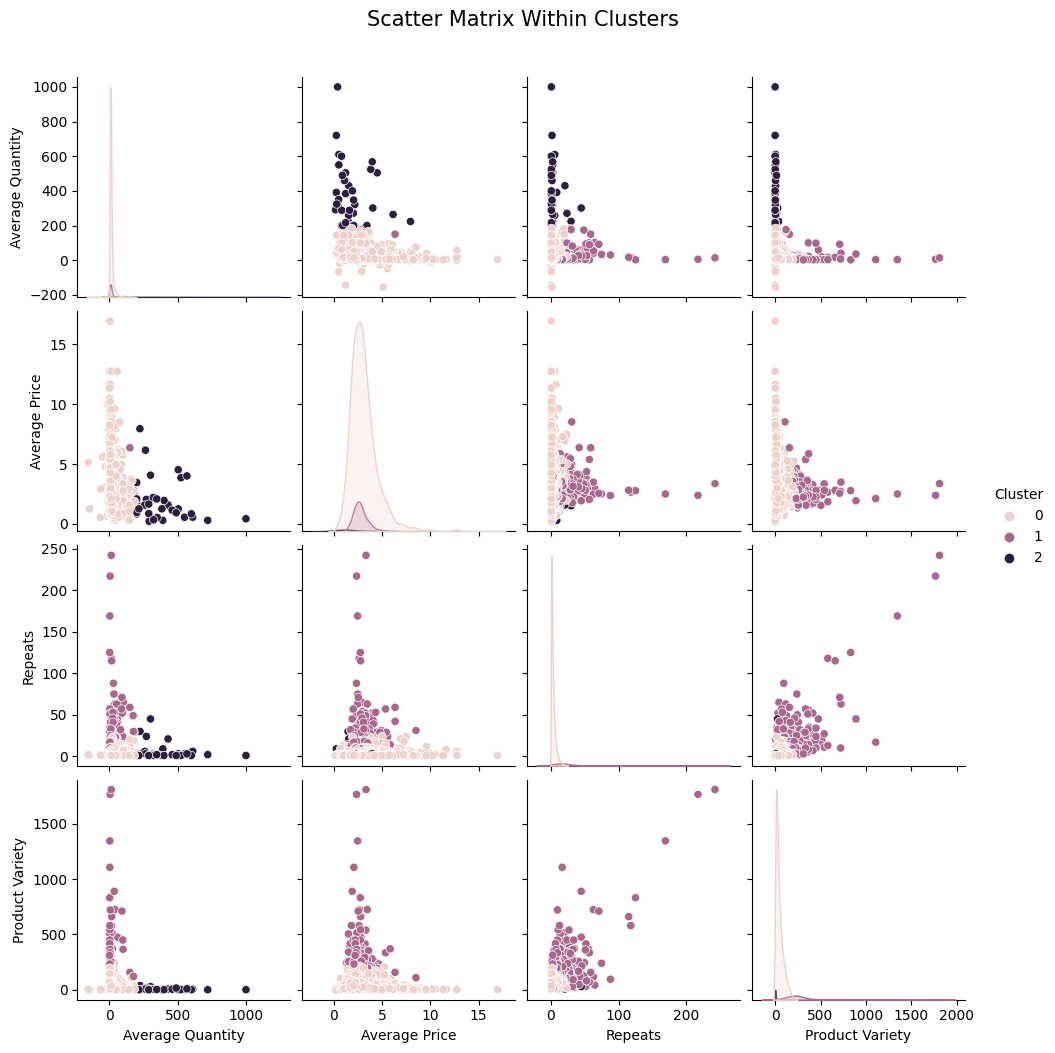

In [11]:
sns.pairplot(data_clustered.drop(columns=['UK?','CustomerID']), hue='Cluster')
plt.suptitle('Scatter Matrix Within Clusters', fontsize = 15, y = 1.05)
plt.show()